In [2]:
import zipfile, struct, warnings, requests, struct
from io import StringIO, BytesIO

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import astropy
from astropy.io.votable import parse_single_table
from astroquery.utils.tap.core import TapPlus
import pvl

# from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
# import plotly
# init_notebook_mode()

from IPython.display import Image, display

%matplotlib inline
warnings.simplefilter('ignore')

# MIDAS data analysis with the PSA and EPN-TAP

## Aims

The aim of this notebook is to demonstrate how to find and use data from the MIDAS Atomic Force Microscope, which flew onboard the Rosetta orbiter. MIDAS collected dust emitted from comet 67P on small targets (called facets), and then scanned them in high resolution using an AFM. This type of microscope doesn't work with light, but scans a very sharp tip over the surface of the particle, building up a 3D picture.

## Methods

Data in ESA's Planetary Science Archive (PSA) can be access in various ways - FTP, web interface, and by machine access. Here we will use the last of these - in particular EPN-TAP. We will introduce this first, since it allows the archive to be queried from a notebook such as this (or a script).

There are several ways you can explore the MIDAS dataset, depending on what kind of question you are trying to answer:
- browse through the images
- look for dust collected at a given time
  - using the exposure history
- use the particle catalogue to search for particles by:
  - size
  - target
  - etc.

To demonstrate the workflow, we will concentrate on the example of a paper published about a dust outburst in February 2016 - Grün, E. et al. The 19 Feb. 2016 Outburst of Comet 67P/CG: An ESA Rosetta Multi-Instrument Study. Mon. Not. R. Astron. Soc. 462, S220–S234 (2016).

## Intro to Jupyter

If you've never used a Jupyter Notebook before, here is a quick intro! Each notoebook mixes text, image and code - in this case in Python. Code cells have a number before them. The notebook has an edit mode and an "action" mode. Hit return when a cell is highlighted and you'll enter edit mode. Press escape to leave it. When you want to execute a cell, use "shift-escape". The menu at theh top gives you more control. If you get really lost, you can restart the kernel - this will clear and value of all variables etc. You can then work your way down from the top of the notebook, following the examples.

There are also some "hidden" cells - if you see three dots (...) on a line, this means that the cell content has been hidden. In this notebook we use this to hide away some of the code used; if you're interested just click the dots to show the cell!

## Intro to EPN-TAP

EPN-TAP is the Europlanet extension of the Table Access Protocol (TAP) commonly used to query data in astronomical archives. The PSA supports EPN-TAP, although with a limited number of fields populated - this will improve, at least for geometry, in the coming months. 

First we have to make a connection to the server:

In [3]:
tap_url = 'https://archives.esac.esa.int/psa/epn-tap/tap/'
psa = TapPlus(url=tap_url)

Created TAP+ (v1.0.1) - Connection:
	Host: archives.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


EPN-TAP uses a SQL-like language to query the database. A simple first query is to count the number of rows (=number of products):

In [4]:
query = 'SELECT COUNT(1) from epn_core'
result = psa.launch_job(query).get_data()
print('Number of products in the PSA: {:d}'.format(result['count'][0]))

Number of products in the PSA: 8859642


Equally there is an column giving the estimated size of each product, which we can sum to get the size of the archive. This is only the size of the latest product for those (PDS4) products that have multiple versions:

In [5]:
query = 'SELECT SUM(access_estsize) from epn_core' 
result = psa.launch_job(query).get_data() # in kbyte
print('Total size of PSA (GB): {:f}'.format(result['sum'][0]/1024./1024./1024.))

Total size of PSA (GB): 51.059374


You can also query selected columns, and order them - for example here we list the top 10 largest products:

In [6]:
query = 'SELECT TOP 10 granule_uid, access_estsize from epn_core WHERE access_estsize IS NOT NULL ORDER BY access_estsize DESC'
result = psa.launch_job(query).get_data()
result

granule_uid,access_estsize
object,int32
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_mir_20160414t023000-20160414t025700-c-0-6,165414637
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_mir_20160414t033000-20160414t035700-c-0-7,165233465
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20161126t015500-20161126t024700-10-9,125029063
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20161126t031300-20161126t040500-10-10,124966100
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20170305t233321-20170306t065000-50-3,102403605
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20170301t230000-20170302t020000-46-2,95586863
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20160614t005100-20160614t014200-0-1,84912674
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20161122t145745-20161122t192620-9-3,67186534
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20170305t192400-20170305t233311-50-2,62398895


# Intro to MIDAS data

- Dust particles were collected by MIDAS during passive exposures
  - a given target was exposed - you can use the "Target History" (TGH) files to explore this

- MIDAS data are archived as 2D height fields
  - i.e. a 2D array of values, each representing the height of the particle at that position
  - meta-data describe the pixel spacing in X and Y
  - and the conversion of the integer height data to real units
  - these are stored in a standard AFM format called BCR
  
- MIDAS stored data from different "channels" representing different modes or types of data
  - ZS data is the main product and shows topography data
  - PH is phase data and relates to the elastic properties of the target
  - other channels give mainly diagnostic information

## Query all MIDAS data at  comet 67P

To demonstrate accessing MIDAS data, we first make a simple query for all data from MIDAS taken at comet 67P:

In [7]:
query = "SELECT * FROM epn_core WHERE target_name='67P' AND instrument_name='MIDAS'"
data = psa.launch_job(query).get_data()
data.info()

<Table masked=True length=2000>
           name             dtype  unit format        description         n_bad
-------------------------- ------- ---- ------ -------------------------- -----
            access_estsize   int32                         access_estsize     0
             access_format  object                          access_format     0
                access_url  object                             access_url     0
                     c1max float64  deg {!r:>}                      c1max  2000
                     c1min float64  deg {!r:>}                      c1min  2000
              c1_resol_max float64  deg {!r:>}               c1_resol_max  2000
              c1_resol_min float64  deg {!r:>}               c1_resol_min  2000
                     c2max float64  deg {!r:>}                      c2max  2000
                     c2min float64  deg {!r:>}                      c2min  2000
              c2_resol_max float64  deg {!r:>}               c2_resol_max  2000
        

The 2k limit on products here is the limit in AstroQuery for synchronous queries - to get more products we could switch to an asynchronous query... The "n_bad" column tells us that many of the fields do not contain useful information - this is because these data are either not available in the PSA, or are not applicable to this instrument ype.

Actually I usually work with pandas, so let's get this into pandas and tidy it up a bit - removing these "bad" fields. Since we do this a lot, we'll define a quick function (tap_to_pandas).

This is an example of one of those hidden cells - you still have to execute it to define the function, but you don't see it. Click the dots to reveal if you like!

In [9]:
def tap_to_pandas(query, tap_handle, remove_nans=True):
    """Execute an EPN-TAP query using the given tap_handle and convert to a 
    pandas dataframe, handling messy utf-8 decoding"""

    data = tap_handle.launch_job(query).get_data().to_pandas()
    if len(data)==0:
        return None
    
    if remove_nans:
        data.dropna(axis=1, how='all', inplace=True)
    
    str_df = data.select_dtypes([np.object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        data[col] = str_df[col]
        
    return data

In [154]:
data = tap_to_pandas(query, psa)
data.iloc[0]

access_estsize                                                      27071
access_format                                       application/x-pds-zip
access_url              https://archives.esac.esa.int/psa/pdap/downloa...
creation_date                                   2019-04-07T14:25:26.19741
dataproduct_type                                                       ci
granule_gid                           RO-C-MIDAS-3-EXT3-SAMPLES-V3.0:DATA
granule_uid             RO-C-MIDAS-3-EXT3-SAMPLES-V3.0:DATA:IMG_162700...
instrument_host_name                                              Rosetta
instrument_name                                                     MIDAS
measurement_type                                                         
modification_date                               2019-04-07T14:25:26.19741
obs_id                  RO-C-MIDAS-3-EXT3-SAMPLES-V3.0:DATA:IMG_162700...
processing_level                                                        5
release_date                          

From the paper: "During the outburst event MIDAS was exposing target 13 as part of a 3-d exposure (2016- 02-16 23:25:25 until 2016-02-20 05:55:19)" The list of exposure is catalogued in target history (TGH) files. These are cumulative, and there is one per possible target.

MIDAS had 64 targets (01-64) so we just need to find the last version of each one. To do this we will query for all data from MIDAS, filter by those with a product ID that starts TGH and ends with nn (target number), order by the end time and pick the top hit (the final target history):

In [11]:
tgh_files = []
for target in np.arange(1,65):
    query = "SELECT TOP 1 * FROM epn_core WHERE instrument_name='MIDAS' AND granule_uid LIKE '%TGH_%_{:02d}' ORDER BY time_max DESC".format(target)
    data = tap_to_pandas(query, psa)
    if data is None:
        continue
    tgh_files.append(data.iloc[0])
tgh = pd.DataFrame(tgh_files)

We will add a new column containing tha target number (last part of the filename, as we used to select above):

In [12]:
tgh['target'] = tgh.granule_uid.apply( lambda x: int(x.split('_')[-1]))

In [13]:
len(tgh)

31

Although MIDAS had 61 scientific targets (and 3 calibration), only 31 were used (either for exposure or scanning). 

Now we know which, we'll grab the target history files and make a dataframe will all this data.... If you were doing this the "old fashioned" way, you would find the last MIDAS dataset (EXT3) and grab the TGH* files in the DATA folder.

In this case EPN-TAP defines an "access_url" which can be used to download a ZIP containng the data product, its label (a text file describing the product), and any linked documentation. We could download the files to disk and open them, but it's just as easy to stream the ZIP, list the files, and open the relevant ones. For this we define a small function "get_lbl_prod" which takes a zip file and returns the names of the product file and label.

In [14]:
def get_lbl_prod(zip):
    """Accepts a zip object and returns the label and data product names from the DATA directory"""

    for filename in zip.namelist():
        if filename == 'inventory.txt': 
            continue
        elif (filename.endswith('.LBL')) and (filename.split('/')[1]=='DATA'):
            label_file = filename
        elif (not filename.endswith('.LBL')) and (filename.split('/')[1]=='DATA'):
            data_file = filename
    
    return label_file, data_file

In [16]:
tgh_cols = ['start_obt', 'start_utc', 'stop_obt', 'stop_utc', 'event', 'tip']
history_cols = tgh_cols + ['target']

history = pd.DataFrame([], columns=history_cols)
for idx, target in tgh.iterrows():
    print('Processing target %d' % target.target)
    r = requests.get(url=target.access_url)
    zip = zipfile.ZipFile(BytesIO(r.content))
    label_file, data_file = get_lbl_prod(zip)
    temp = pd.read_table(zip.open(data_file), sep=',', delim_whitespace=False, header=None, names=tgh_cols)
    temp['target'] = target.target
    history = history.append(temp)
    
history.start_utc = pd.to_datetime(history.start_utc)
history.stop_utc = pd.to_datetime(history.stop_utc)
history.sort_values(by='start_utc', inplace=True)
history = history.set_index(np.arange(len(history)))

Processing target 1
Processing target 2
Processing target 3
Processing target 4
Processing target 5
Processing target 6
Processing target 7
Processing target 8
Processing target 9
Processing target 10
Processing target 11
Processing target 12
Processing target 13
Processing target 14
Processing target 15
Processing target 16
Processing target 17
Processing target 18
Processing target 19
Processing target 20
Processing target 21
Processing target 22
Processing target 23
Processing target 24
Processing target 25
Processing target 33
Processing target 34
Processing target 35
Processing target 36
Processing target 37
Processing target 44


In [88]:
len(history)

1311

In [89]:
history.event.unique()

array(['EXPOSURE', 'SCANNING'], dtype=object)

OK, so only two types of events are described for each target - exposure or scanning. For convenience let's get a list of the exposures only, and also calculated their duration:

In [90]:
exposures = history[history.event=='EXPOSURE']
exposures['duration'] = exposures.stop_utc - exposures.start_utc
len(exposures)

178

Now we are going to look for exposures during an outburst. Exposures were often for days, or even weeks, so we'll examine a window of one week either side of the outburst date:

In [91]:
outburst_day_start = pd.Timestamp('2016-02-19 00:00:00')
outburst_day_stop = pd.Timestamp('2016-02-19 23:59:59')

# add a one-week delta-time
search_start = outburst_day_start - pd.Timedelta(weeks=1)
search_stop = outburst_day_stop + pd.Timedelta(weeks=1)

In [92]:
exposures[ (exposures.start_utc >= search_start) & (exposures.stop_utc <= search_stop) ]

,start_obt,start_utc,stop_obt,stop_utc,event,tip,target,duration
904,4.139406e+08,2016-02-12 23:31:24.667,4.139636e+08,2016-02-13 05:55:19.417,EXPOSURE,1,14,0 days 06:23:54.750000
912,4.144413e+08,2016-02-18 18:35:52.941,4.145684e+08,2016-02-20 05:55:19.867,EXPOSURE,16,14,1 days 11:19:26.926000
914,4.146628e+08,2016-02-21 08:07:26.400,4.147960e+08,2016-02-22 21:08:20.757,EXPOSURE,2,14,1 days 13:00:54.357000
917,4.148903e+08,2016-02-23 23:19:26.328,4.149104e+08,2016-02-24 04:55:01.518,EXPOSURE,1,14,0 days 05:35:35.190000


OK, so MIDAS was exposing around this event (row 912), but also a couple of days after. Note that hte short, 6 hour exposures, were during periods when the spacecraft thrusters were firing and it was deemd too dangerous to scan, but the time could be used for additional exposures.

In [95]:
exposure = exposures.loc[912]
exposure

start_obt                   4.14441e+08
start_utc    2016-02-18 18:35:52.941000
stop_obt                    4.14568e+08
stop_utc     2016-02-20 05:55:19.867000
event                          EXPOSURE
tip                                  16
target                               14
duration         1 days 11:19:26.926000
Name: 912, dtype: object

OK, so now we know which target was exposed, and for how long, during the outburst. Many targets were exposed multiple times (because "pre-scanning" to see what was there before exposure was very time-consuming, and it was more efficient to re-use targets). To see if we have any scans uniquely looking at dust collected in this exposure, we will look at the history of this target shortly after the given exposure:

In [96]:
history[ (history.start_utc >= exposure.start_utc) & (history.target==exposure.target) ].head(10)

,start_obt,start_utc,stop_obt,stop_utc,event,tip,target
912,4.144413e+08,2016-02-18 18:35:52.941,4.145684e+08,2016-02-20 05:55:19.867,EXPOSURE,16,14
914,4.146628e+08,2016-02-21 08:07:26.400,4.147960e+08,2016-02-22 21:08:20.757,EXPOSURE,2,14
916,4.148903e+08,2016-02-23 23:19:26.328,4.155193e+08,2016-03-02 06:02:52.693,EXPOSURE,1,14
917,4.148903e+08,2016-02-23 23:19:26.328,4.149104e+08,2016-02-24 04:55:01.518,EXPOSURE,1,14
919,4.149559e+08,2016-02-24 17:32:36.396,4.150251e+08,2016-02-25 12:46:51.418,SCANNING,11,14
938,4.161324e+08,2016-03-09 08:21:08.772,4.162141e+08,2016-03-10 07:03:48.798,SCANNING,11,14
939,4.162431e+08,2016-03-10 15:06:11.807,4.163247e+08,2016-03-11 13:46:22.833,SCANNING,11,14
945,4.167489e+08,2016-03-16 11:37:11.969,4.167740e+08,2016-03-16 18:35:04.977,SCANNING,1,14
947,4.169969e+08,2016-03-19 08:30:00.048,4.171010e+08,2016-03-20 13:25:10.081,SCANNING,1,14
948,4.171340e+08,2016-03-20 22:34:35.092,4.171589e+08,2016-03-21 05:30:01.100,SCANNING,1,14


Unfortunately further exposures were commanded of this target _before_ any scans, so whilst we can hypothesise that any dust seen in subsequent scans was emitted during the ouburst, one cannot be 100% sure. Now we already see the first scan of this target after the exposure.

To proceed, we want to get a list of the images taken of target 14 after the end of the exposure. Whilst the target number is stored as meta-data in the PDS label, it is not exposed to the EPN-TAP interface. But, as you see above, we have a list of scan start times which we **can** search for.  The EPN-TAP date column stores a Julian date, so we will have to convert the date to this format....

We will first see if there rae _any_ other exposures on target 14 beyond the ones identified above:

In [99]:
exposures[ (exposures.start_utc >= history.loc[912].stop_utc) & (exposures.target==exposure.target) ]

,start_obt,start_utc,stop_obt,stop_utc,event,tip,target,duration
914,4.146628e+08,2016-02-21 08:07:26.400,4.147960e+08,2016-02-22 21:08:20.757,EXPOSURE,2,14,1 days 13:00:54.357000
916,4.148903e+08,2016-02-23 23:19:26.328,4.155193e+08,2016-03-02 06:02:52.693,EXPOSURE,1,14,7 days 06:43:26.365000
917,4.148903e+08,2016-02-23 23:19:26.328,4.149104e+08,2016-02-24 04:55:01.518,EXPOSURE,1,14,0 days 05:35:35.190000


No, this target was not used again after the last exposure shown - so any scans after this point should be useful.

In [104]:
scan_times = history[ (history.target==exposure.target) & (history.event=='SCANNING') & (history.start_utc > exposures.loc[917].stop_utc)].start_utc

In [155]:
len(scan_times)

216

Now we have two ways to get these images and analyse them - we can use the particle catalogue, or we can simply query and display the relevant image scans. First we are going to use EPN-TAP to return all topographic images matching these times. We search for all MIDAS data with as start time in a +/- 1 minute window of the value we found before, and filter on the product name - this is useful since MIDAS topographc images all end ZS (Z set point):

In [136]:
images = []
for start_time in scan_times:
    start = (start_time-pd.Timedelta(minutes=1)).to_julian_date()
    end = (start_time+pd.Timedelta(minutes=1)).to_julian_date()         
    query = "SELECT * FROM epn_core WHERE target_name='67P' AND instrument_name='MIDAS' AND time_min>'%s' and time_min<'%s' and processing_level=5 and granule_uid like '%%ZS'" % (start, end)
    data = tap_to_pandas(query, psa)
    if data is None:
        continue
    images.append(data.iloc[0])
images = pd.DataFrame(images)

### Delving into one image

OK. now we have a list of MIDAS image scans made of dust probably collected during the outburst discussed in the paper. Let's pick the first one and see what we can see:

In [156]:
image = images.iloc[0]
image

access_estsize                                                      27178
access_format                                       application/x-pds-zip
access_url              https://archives.esac.esa.int/psa/pdap/downloa...
creation_date                                   2019-04-07T14:25:26.19741
dataproduct_type                                                       ci
granule_gid                           RO-C-MIDAS-3-EXT1-SAMPLES-V3.0:DATA
granule_uid             RO-C-MIDAS-3-EXT1-SAMPLES-V3.0:DATA:IMG_160402...
instrument_host_name                                              Rosetta
instrument_name                                                     MIDAS
measurement_type                                                         
modification_date                               2019-04-07T14:25:26.19741
obs_id                  RO-C-MIDAS-3-EXT1-SAMPLES-V3.0:DATA:IMG_160402...
processing_level                                                        5
release_date                          


Ooh there is a thumbnail_url - let's look at that:

In [157]:
image.thumbnail_url

'https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/RO-C-MIDAS-3-EXT1-SAMPLES-V3.0/BROWSE/PRV_1604023_1606900_044_ZS.JPG'

So it's a simple JPG that we can probably view:

In [158]:
Image(url=image.thumbnail_url)

As well as a thumbnail URL, the database entry points to how we can download the actual data:

In [159]:
image.access_url

'https://archives.esac.esa.int/psa/pdap/download?CLIENT=epntap&RESOURCE_CLASS=PRODUCT&ID=RO-C-MIDAS-3-EXT1-SAMPLES-V3.0:DATA:IMG_1604023_1606900_044_ZS'

In [160]:
r = requests.get(url=image.access_url)
zip = zipfile.ZipFile(BytesIO(r.content))
zip.namelist()

['RO-C-MIDAS-3-EXT1-SAMPLES-V3.0/DOCUMENT/MID_EAICD.PDF',
 'RO-C-MIDAS-3-EXT1-SAMPLES-V3.0/BROWSE/PRV_1604023_1606900_044_ZS.JPG',
 'RO-C-MIDAS-3-EXT1-SAMPLES-V3.0/DOCUMENT/MID_CALIBRATION.PDF',
 'RO-C-MIDAS-3-EXT1-SAMPLES-V3.0/DOCUMENT/MID_TIP_IMAGES.PDF',
 'RO-C-MIDAS-3-EXT1-SAMPLES-V3.0/DATA/IMG/IMG_1604023_1606900_044_ZS.LBL',
 'RO-C-MIDAS-3-EXT1-SAMPLES-V3.0/DATA/IMG/IMG_1604023_1606900_044_ZS.IMG',
 'RO-C-MIDAS-3-EXT1-SAMPLES-V3.0/BROWSE/PRV_1604023_1606900_044_ZS.LBL',
 'inventory.txt']

This zip contains quite a lot of information, since it automatically includes documents of relevance. For now we just want the image file and label in the data directory:

In [161]:
label_file, data_file = get_lbl_prod(zip)

The label file is a PDS3 label in a format called PVL - there is a library for this so we can load and parse the label:

In [163]:
label = pvl.load(zip.open(label_file))

The raw data file we will just read into memory to process later:

In [164]:
rawdata = zip.open(data_file).read()

Now we need to know a bit more - if you browse the label more carefully you can see that the .IMG file contains two parts - an ASCII header with a fixed length of 2048 bytes, and some binary data. 

In [165]:
offset = label['BCR_HEADER']['BYTES']
zcal = float(label['BCR_IMAGE']['SCALING_FACTOR'])
xpix = int(label['BCR_IMAGE']['LINE_SAMPLES'])
ypix = int(label['BCR_IMAGE']['LINES'])
xpix_m = float(label['HORIZONTAL_PIXEL_SCALE'])
ypix_m = float(label['VERTICAL_PIXEL_SCALE'])
xlen_nm = xpix_m * xpix * 1.e9
ylen_nm = ypix_m * xpix * 1.e9
length = xpix * ypix

Data are stored as little-endian signed integers - simply read them using the struct module, re-shape according to the label data, rescale so that zero is the minimum and multiply by the Z (height) calibration factor.

In [166]:
data = np.array(struct.unpack('<%dh'%length, rawdata[offset:]), dtype=np.float)
data = data.reshape(xpix,ypix)
data -= data.min()
data *= zcal

Now plot this - firstly simply using Matplotlib:

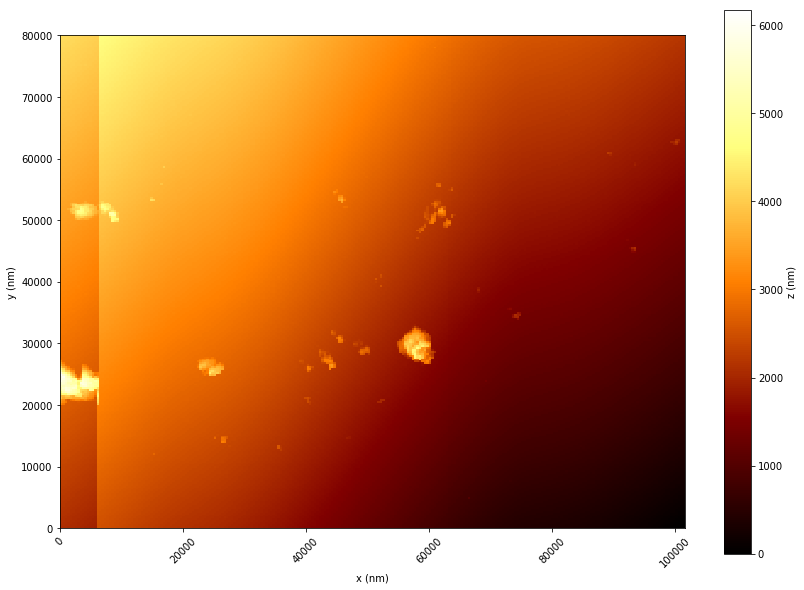

In [167]:
fig, ax = plt.subplots(figsize=(14,10))
extent = [0., xlen_nm, 0., ylen_nm]
im = ax.imshow(data, interpolation='nearest', extent=extent, cmap=plt.cm.afmhot)
cbar = plt.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
cbar.set_label('z (nm)')

Great, this looks like the preview image above! We can also display in 3D and interactive using plotly:

In [168]:
xvals = np.linspace(0., xlen_nm, num=xpix)
yvals = np.linspace(0., ylen_nm, num=ypix)
xs, ys = np.meshgrid(xvals, yvals)
img_data = [ go.Surface(x=xs, y=ys, z=data/100.) ]
layout = go.Layout(title=image.product_id, autosize=True, width=800, height=550, margin=dict(l=65, r=50, b=65, t=90), scene = dict(aspectmode='data'))
go.FigureWidget(data=img_data, layout=layout)#, config={'showLink': False, 'displaylogo': False, 'modeBarButtonsToRemove': ['sendDataToCloud']})

AttributeError: 'Series' object has no attribute 'product_id'

To make our life a bit easier, we'll define a function here that accepts the granule_uid of a product (e.g. from a previous search) and grabs this data and plots it with MPL (plot_by_uid)

In [169]:
def plot_by_uid(uid, tap_handle):
    """Accepts an EPN-TAP granule_uid for a MIDAS product, uses the access_url to
    download the zipped product, parses the label and uses the meta-data to
    plot the image product in 2D"""
    
    query = "SELECT * FROM epn_core WHERE granule_uid='%s'" % uid
    table = tap_handle.launch_job(query).get_data()
    
    if len(table) == 0:
        print('ERROR: this uid does not exist')
    elif len(table) > 1:
        print('ERROR: more than one product match this uid')
    else:
        access_url = table[0]['access_url'].decode('utf-8')
        
        r = requests.get(url=access_url)
        zip = zipfile.ZipFile(BytesIO(r.content))
        label_file = [filename for filename in zip.namelist() if (filename.endswith('.LBL') and filename.split('/')[1]=='DATA')][0]
        label = pvl.load(zip.open(label_file))
        data_file = [filename for filename in zip.namelist() if (filename.endswith('.IMG') and filename.split('/')[1]=='DATA')][0]
        rawdata = zip.open(data_file).read()
        
        offset = label['BCR_HEADER']['BYTES']
        zcal = float(label['BCR_IMAGE']['SCALING_FACTOR'])
        xpix = int(label['BCR_IMAGE']['LINE_SAMPLES'])
        ypix = int(label['BCR_IMAGE']['LINES'])
        xpix_m = float(label['HORIZONTAL_PIXEL_SCALE'])
        ypix_m = float(label['VERTICAL_PIXEL_SCALE'])
        xlen_nm = xpix_m * xpix * 1.e9
        ylen_nm = ypix_m * xpix * 1.e9
        length = xpix * ypix
        
        data = np.array(struct.unpack('<%dh'%length, rawdata[offset:]), dtype=np.float)
        data = data.reshape(xpix,ypix)
        data -= data.min()
        data *= zcal

        fig, ax = plt.subplots(figsize=(14,10))
        extent = [0., xlen_nm, 0., ylen_nm]
        im = ax.imshow(data, interpolation='nearest', extent=extent, cmap=plt.cm.afmhot)
        cbar = plt.colorbar(im)
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.set_xlabel('x (nm)')
        ax.set_ylabel('y (nm)')
        # cbar.set_label('z (nm)')

We can now, for example, take the UID of any of the images in our table and display it. Let's take the last one:

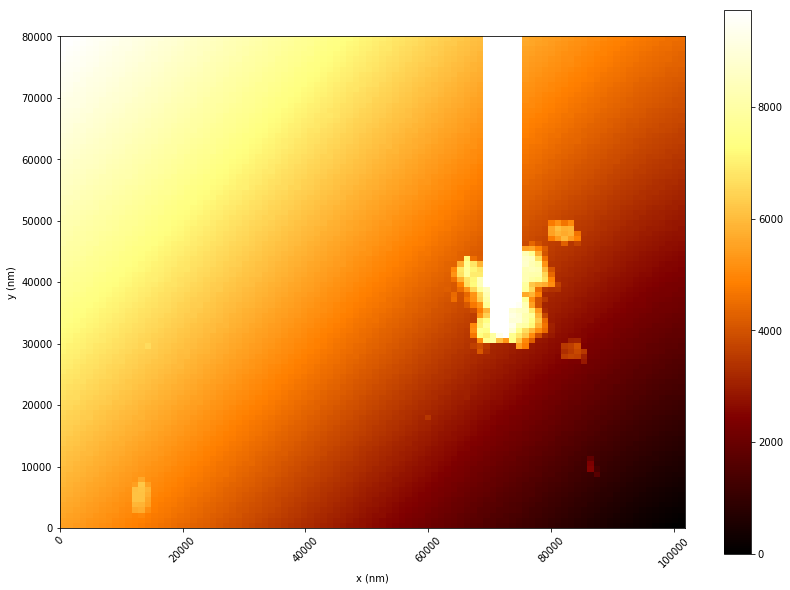

In [172]:
plot_by_uid(images.granule_uid.iloc[-1], psa)

## The particle catalogue

A new, derived, product was recently added to the MIDAS archive - the particle catalogue. This is a table derived from the images by the MIDAS team and identifies cometary particles, along with giving some key parameters. It has a known name and we can find it easily:

In [173]:
prod_id = 'MID_PARTICLE_TABLE'

In [174]:
query = "SELECT * FROM epn_core WHERE instrument_name='MIDAS' AND GRANULE_UID LIKE '%MID_PARTICLE_TABLE'"
data = psa.launch_job(query).get_data()
data['granule_uid']

RO-C-MIDAS-5-PRL-TO-EXT3-V1.0:DATA:MID_PARTICLE_TABLE


As expected, we have one single product returned. We can grab the table and its label as a zip as for an image file, and load it in

In [175]:
catalogue_url = data['access_url'].data[0]

In [176]:
r = requests.get(url=catalogue_url)
zip = zipfile.ZipFile(BytesIO(r.content))
zip.namelist()

['RO-C-MIDAS-5-PRL-TO-EXT3-V1.0/DATA/MID_PARTICLE_TABLE.TAB',
 'RO-C-MIDAS-5-PRL-TO-EXT3-V1.0/DATA/MID_PARTICLE_TABLE.LBL',
 'inventory.txt']

In [177]:
label_file, data_file = get_lbl_prod(zip)

We don't have a good PDS3 reader in python, but here we will use the label to extract the column names and load it into a pandas DataFrame:

In [178]:
label = pvl.load(zip.open(label_file))   
table_meta = label['PARTICLE_TABLE']

# extract the column names from the label file
cols = []
for item in table_meta:
    if item[0] != 'COLUMN':
        continue
    cols.append(item[1]['NAME'])

# read the CSV file
catalogue = pd.read_table(zip.open(data_file), sep=',', delim_whitespace=False, names=cols, skiprows=1)

# tidy it up a bits
for col in catalogue.columns:
    if catalogue[col].dtype == 'O':
        catalogue[col] = catalogue[col].str.strip()

In [179]:
catalogue.head()

,PARTICLE_ID,PARTICLE_SCAN_FILE,PARTICLE_MASK_FILE,PRE_SCAN_FILE,PRE_SCAN_FLAG,PARTICLE_FLAG,SCAN_QUALITY_FLAG,MULTIPLE_FRAGMENTS_FLAG,TRUST_HEIGHT_FLAG,PHYSICAL_ALTERATION_FLAG,...,X_SCAN_SIZE,Y_SCAN_SIZE,TIP_NUMBER,TARGET_NUMBER,LAST_TIP_IMAGE_START,ARCHIVE_FILE_LAST_TIP_IMAGE,BOUNDING_BOX_ROW_MIN,BOUNDING_BOX_ROW_MAX,BOUNDING_BOX_COL_MIN,BOUNDING_BOX_COL_MAX
0,2014-11-14T120150_P01_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,2,0,1,0,...,80.3,80.3,5,10,,,0,6,27,32
1,2014-11-14T120150_P02_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,3,0,2,0,...,80.3,80.3,5,10,,,14,18,0,6
2,2014-11-14T120150_P03_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,3,0,2,0,...,80.3,80.3,5,10,,,10,30,26,186
3,2014-11-14T120150_P04_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,3,0,2,0,...,80.3,80.3,5,10,,,31,36,153,164
4,2014-11-14T120150_P05_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,3,0,2,0,...,80.3,80.3,5,10,,,31,36,0,26


So now we have a **lot** of columns:

In [180]:
catalogue.columns

Index(['PARTICLE_ID', 'PARTICLE_SCAN_FILE', 'PARTICLE_MASK_FILE',
       'PRE_SCAN_FILE', 'PRE_SCAN_FLAG', 'PARTICLE_FLAG', 'SCAN_QUALITY_FLAG',
       'MULTIPLE_FRAGMENTS_FLAG', 'TRUST_HEIGHT_FLAG',
       'PHYSICAL_ALTERATION_FLAG', 'LINKED_PARTICLE_ID',
       'LINKED_PARTICLE_SCAN', 'LINKED_PARTICLE_FLAG', 'MASTER_PARTICLE_ID',
       'MASTER_PARTICLE_SCAN', 'AREA_PIXEL', 'AREA_UM', 'Z_MIN_VALUE',
       'Z_MAX_VALUE', 'Z_MEAN_VALUE', 'PARTICLE_HEIGHT', 'PARTICLE_STD_DEV',
       'X_STEP_SIZE', 'Y_STEP_SIZE', 'X_SCAN_ORIGIN', 'Y_SCAN_ORIGIN',
       'X_SCAN_SIZE', 'Y_SCAN_SIZE', 'TIP_NUMBER', 'TARGET_NUMBER',
       'LAST_TIP_IMAGE_START', 'ARCHIVE_FILE_LAST_TIP_IMAGE',
       'BOUNDING_BOX_ROW_MIN', 'BOUNDING_BOX_ROW_MAX', 'BOUNDING_BOX_COL_MIN',
       'BOUNDING_BOX_COL_MAX'],
      dtype='object')

OK, let's find the largest (area) particles in the catalogue:

In [181]:
catalogue.sort_values(by='AREA_UM', ascending=False)[['PARTICLE_SCAN_FILE', 'AREA_UM']].head(5)

,PARTICLE_SCAN_FILE,AREA_UM
660,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_161...,4473.801
664,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_161...,2151.731
1037,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1615223_161...,2116.979
656,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_161...,1853.348
601,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1609623_161...,1721.125


Let's see if we can retrieve the scan of the largest particle    

In [182]:
largest = catalogue.sort_values(by='AREA_UM', ascending=False).iloc[0]
largest

PARTICLE_ID                                            2016-05-08T174029_P01_T13
PARTICLE_SCAN_FILE             RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_161...
PARTICLE_MASK_FILE             RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_161...
PRE_SCAN_FILE                                                                   
PRE_SCAN_FLAG                                                                  0
PARTICLE_FLAG                                                                  1
SCAN_QUALITY_FLAG                                                              2
MULTIPLE_FRAGMENTS_FLAG                                                        0
TRUST_HEIGHT_FLAG                                                              2
PHYSICAL_ALTERATION_FLAG                                                       0
LINKED_PARTICLE_ID                                                              
LINKED_PARTICLE_SCAN                                                            
LINKED_PARTICLE_FLAG        

In [183]:
largest_id = largest['PARTICLE_SCAN_FILE']

We need to convert the dataset and product ID from the catalogue into the granule UID  used in EPN-TAP:

In [184]:
largest_uid = largest_id.split('/')[0] + ':DATA:' + largest_id.split('/')[1]
largest_uid

'RO-C-MIDAS-3-EXT2-SAMPLES-V3.0:DATA:IMG_1612423_1615300_019_ZS'

Now we can check if this product exists in the archive:

In [185]:
query = "SELECT * FROM epn_core WHERE granule_uid='%s'" % largest_uid
data = psa.launch_job(query).get_data()
data

access_estsize,access_format,access_url,c1max,c1min,c1_resol_max,c1_resol_min,c2max,c2min,c2_resol_max,c2_resol_min,c3max,c3min,c3_resol_max,c3_resol_min,creation_date,dataproduct_type,emergence_max,emergence_min,granule_gid,granule_uid,incidence_max,incidence_min,instrument_host_name,instrument_name,measurement_type,modification_date,obs_id,phase_max,phase_min,processing_level,release_date,service_title,spatial_frame_type,spectral_range_max,spectral_range_min,spectral_resolution_max,spectral_resolution_min,spectral_sampling_step_max,spectral_sampling_step_min,s_region,target_class,target_name,thumbnail_url,time_exp_max,time_exp_min,time_max,time_min,time_sampling_step_max,time_sampling_step_min
,,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,deg,deg,,,deg,deg,,,,,,deg,deg,,,,,Hz,Hz,Hz,Hz,Hz,Hz,,,,,s,s,d,d,s,s
int32,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,object,object,float64,float64,object,object,object,object,object,float64,float64,int32,object,object,object,float64,float64,float64,float64,float64,float64,object,object,object,object,float64,float64,float64,float64,float64,float64
27084,application/x-pds-zip,https://archives.esac.esa.int/psa/pdap/download?CLIENT=epntap&RESOURCE_CLASS=PRODUCT&ID=RO-C-MIDAS-3-EXT2-SAMPLES-V3.0:DATA:IMG_1612423_1615300_019_ZS,--,--,--,--,--,--,--,--,--,--,--,--,2019-04-07T14:25:26.19741,ci,--,--,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0:DATA,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0:DATA:IMG_1612423_1615300_019_ZS,--,--,Rosetta,MIDAS,,2019-04-07T14:25:26.19741,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0:DATA:IMG_1612423_1615300_019_ZS,--,--,5,2019-03-15T00:00:00.0,psa,none,--,--,--,--,--,--,,comet,67P,https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/BROWSE/PRV_1612423_1615300_019_ZS.JPG,--,--,2457517.5056305323,2457517.2364522107,--,--


So we have a single product - let's look at the browse product for this:

In [186]:
thumbnail_url = data['thumbnail_url'].data[0].decode('utf-8')
Image(url=thumbnail_url)

OK, interesting... what parts of this image did the MIDAS team classify as a particle? We can look for a corresponding particle mask, also provided by the team. This is refered to in the catalogue in the column PARTICLE_MASK_FILE.

In [187]:
mask_id = largest.PARTICLE_MASK_FILE
mask_id

'RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_1615300_019_MK'

In [188]:
mask_uid = mask_id.split('/')[0] + ':DATA:' + mask_id.split('/')[1]
mask_uid

'RO-C-MIDAS-3-EXT2-SAMPLES-V3.0:DATA:IMG_1612423_1615300_019_MK'

Now we can use our new plotting function above to test this:

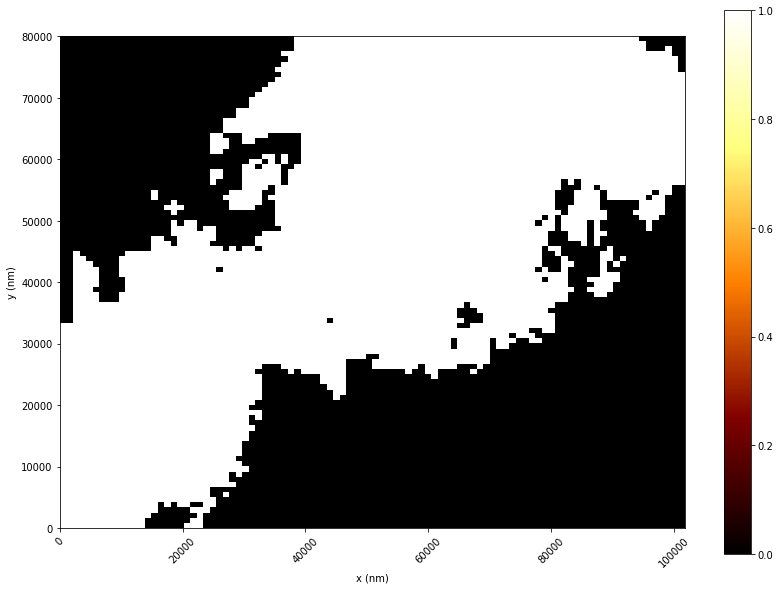

In [189]:
plot_by_uid(mask_uid, psa)

OK, one last thing - let's see what the particle catalogue can tell us about the distribution or parameters of dust particles collected on target 14 during this probably outburst collection.

In [193]:
tar14_pcles = catalogue[ catalogue.TARGET_NUMBER==13 ]
len(tar14_pcles)

970

In [198]:
tar14_pcles.AREA_UM.describe()

count     970.000000
mean       48.567837
std       211.520728
min         0.112000
25%         3.964000
50%         9.911000
75%        26.190500
max      4473.801000
Name: AREA_UM, dtype: float64

In [199]:
tar14_pcles.PARTICLE_HEIGHT.describe()

count    970.000000
mean       1.745701
std        1.511075
min        0.000000
25%        0.720000
50%        1.240000
75%        2.332500
max        9.270000
Name: PARTICLE_HEIGHT, dtype: float64